In [18]:
%load_ext autoreload
%autoreload 2
import tonic
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torch
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import numpy as np
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
ROOT_DIR = "/home/aryalohia/PycharmProjects/iris/version-2"
results_dir = os.path.join(ROOT_DIR, 'VSim_dataset/', 'results/')
model_dir = os.path.join(ROOT_DIR, 'models/')

In [20]:
# animation = tonic.utils.plot_animation(frames=convert_to_frame.detach().cpu())
# animation.save("data_sample.mp4")

In [21]:
# PARAMETERS
batch_size = 1
sensor_size = (240, 180, 2) # Davis240

In [25]:
# DATA
from oms_generalized_kernels.event_dataset import IrisDVSDataset

frame_transform = tonic.transforms.Compose([])

train_dataset = IrisDVSDataset(
    sensor_size=sensor_size,
    transform=frame_transform,
    data_dir=results_dir
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Pytorch Dataloader
test_loader = None  # Pytorch Dataloader


converted `data_dir` to relative path: ../VSim_dataset/results
Loading training VSim_dataset from events.h5 and ref-events.h5 files, or from .npy files if already converted
All input-events are converted to event-frames
All reference-events are converted to event-frames
All events-frame files are ready
Dataset is ready to be used 


In [26]:
def plot_animation(frames: np.ndarray, figsize = (5, 5), save_path = None):
    """Helper function that animates a tensor of frames of shape (TCHW). If you run this in a
    Jupyter notebook, you can display the animation inline like shown in the example below.

    Parameters:
        frames: numpy array or tensor of shape (TCHW)
        figsize: tuple(int, int) specifying the size of the figure

    Example:
        >>> import tonic
        >>> nmnist = tonic.datasets.NMNIST(save_to='./data', train=False)
        >>> events, label = nmnist[0]
        >>>
        >>> transform = tonic.transforms.ToFrame(
        >>>     sensor_size=nmnist.sensor_size,
        >>>     time_window=10000,
        >>> )
        >>>
        >>> frames = transform(events)
        >>> animation = tonic.utils.plot_animation(frames)
        >>>
        >>> # Display the animation inline in a Jupyter notebook
        >>> from IPython.display import HTML
        >>> HTML(animation.to_jshtml())

    Returns:
        The animation object. Store this in a variable to keep it from being garbage collected until displayed.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib import animation
    except ImportError:
        raise ImportError(
            "Please install the matplotlib package to plot events. This is an optional"
            " dependency."
        )
    fig = plt.figure(figsize=figsize)
    if frames.shape[1] == 2:
        rgb = np.zeros((frames.shape[0], 3, *frames.shape[2:]))
        rgb[:, 1:, ...] = frames
        frames = rgb
    if frames.shape[1] in [1, 2, 3]:
        frames = np.moveaxis(frames, 1, 3)

    frames = (frames / frames.max()) * 255

    print(frames.shape)

    import skvideo.io
    from tqdm import tqdm
    writer = skvideo.io.FFmpegWriter(save_path, inputdict={"-r": str(1000)},
                                     outputdict={'-vcodec': 'libx264', '-r': str(1000)},
                                     verbosity=1)

    for i in tqdm(range(frames.shape[0]), desc="writing video"):
        writer.writeFrame(frames[i])

    # Release capture and destroy windows
    writer.close()
    return

In [44]:
# NETWORK
device = torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")

from oms_generalized_kernels.oms_v3_network import OMSV3Network
net = OMSV3Network(center_rad=2, surround_rad=5)
net.load_state_dict(torch.load(os.path.join(model_dir, "Mon_Aug_14_15:19:18_2023.pth")))
net.eval()

OMSV3Network(
  (center): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (surround): Conv2d(1, 1, kernel_size=(10, 10), stride=(1, 1), padding=same)
)

In [45]:
from tqdm import tqdm

def forward_pass(net, data):
    # VSim_dataset should be shape (num time steps, batch_size, channels, height, width)
    # net.to(device)
    # VSim_dataset.to(device)

    batch_size = data.shape[0]
    num_time_steps = data.shape[1]

    data = data.reshape(num_time_steps, batch_size, 2, 180, 240)
    data = data[:, :, 0] + data[:, :, 1]

    out_rec = []

    for step in tqdm(range(data.shape[0])):  # VSim_dataset.size(0) = number of time steps
        # print(data[step].shape)
        out = net(data[step] / data[step].max())  # norm VSim_dataset to 1

        out[np.where(out >= .4)] = 1
        out[np.where(out < .4)] = 0

        out_rec.append(out.view(batch_size, 1, 180, 240))

    return torch.stack(out_rec)



In [46]:
# first_forward = net(torch.from_numpy(train_dataset[5][0][np.newaxis, ...]).float().reshape(-1, batch_size, 2, 180, 240)[0])
first_forward = forward_pass(net, torch.from_numpy(train_dataset[0][0][np.newaxis, ...]).float())

100%|██████████| 4991/4991 [00:28<00:00, 175.80it/s]


In [47]:
first_forward.max()

tensor(1., grad_fn=<MaxBackward1>)

In [48]:
experiment = first_forward.detach().numpy()

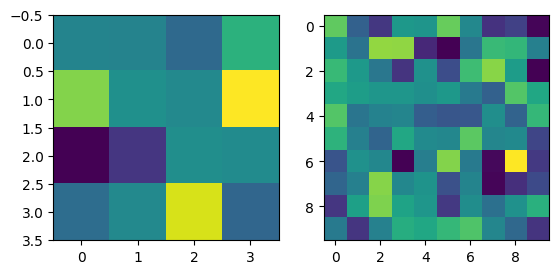

In [50]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(net.conv_filters[0].squeeze())
ax[1].imshow(net.conv_filters[1].squeeze())
# net.conv_filters

In [51]:
animation = plot_animation(frames=np.float64(first_forward[:, 0].detach().numpy()), save_path=os.path.join(model_dir, "0.0.mp4"));

(4991, 180, 240, 1)


writing video:   0%|          | 0/4991 [00:00<?, ?it/s]ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enab

/usr/bin/ffmpeg -y -r 1000 -f rawvideo -pix_fmt gray -s 240x180 -i - -vcodec libx264 -r 1000 /home/aryalohia/PycharmProjects/iris/version-2/models/0.0.mp4


Input #0, rawvideo, from 'pipe:':
  Duration: N/A, start: 0.000000, bitrate: 345600 kb/s
  Stream #0:0: Video: rawvideo (Y800 / 0x30303859), gray, 240x180, 345600 kb/s, 1k tbr, 1k tbn, 1k tbc
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> h264 (libx264))
[libx264 @ 0x555560f73c00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x555560f73c00] profile High, level 3.2, 4:0:0, 8-bit
[libx264 @ 0x555560f73c00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=0 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=6 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=4

<Figure size 500x500 with 0 Axes>

In [20]:
import skvideo.io
from tqdm import tqdm
writer = skvideo.io.FFmpegWriter(os.path.join(model_dir, "0.0.mp4"), inputdict={"-r": str(1000)},
                                  outputdict={'-vcodec': 'libx264', '-r': str(1000)},
                                  verbosity=1)

for i in tqdm(range(first_forward.shape[0]), desc="writing video"):
    writer.writeFrame(first_forward[i].view(180, 240).detach().cpu().numpy() * 255)

# Release capture and destroy windows
writer.close()

writing video:   0%|          | 0/4991 [00:00<?, ?it/s]ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enab

/usr/bin/ffmpeg -y -r 1000 -f rawvideo -pix_fmt gray -s 240x180 -i - -vcodec libx264 -r 1000 /home/aryalohia/PycharmProjects/Pseudo-Object-Motion-Sensitivity-in-Python-V1/models/0.0.mp4


writing video: 100%|██████████| 4991/4991 [00:00<00:00, 11261.44it/s]
frame= 4991 fps=0.0 q=-1.0 Lsize=     134kB time=00:00:04.98 bitrate= 219.6kbits/s speed=13.6x    
video:74kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 79.553947%
[libx264 @ 0x55f1bfd02c00] frame I:20    Avg QP:11.15  size:    52
[libx264 @ 0x55f1bfd02c00] frame P:1257  Avg QP:14.07  size:    20
[libx264 @ 0x55f1bfd02c00] frame B:3714  Avg QP:17.67  size:    13
[libx264 @ 0x55f1bfd02c00] consecutive B-frames:  0.8%  0.0%  0.0% 99.2%
[libx264 @ 0x55f1bfd02c00] mb I  I16..4: 100.0%  0.0%  0.0%
[libx264 @ 0x55f1bfd02c00] mb P  I16..4:  0.0%  0.0%  0.0%  P16..4:  0.0%  0.0%  0.0%  0.0%  0.0%    skip:100.0%
[libx264 @ 0x55f1bfd02c00] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.0%  0.0%  0.0%  direct: 0.0%  skip:100.0%
[libx264 @ 0x55f1bfd02c00] 8x8 transform intra:0.0%
[libx264 @ 0x55f1bfd02c00] coded y intra: 0.0% inter: 0.0%
[libx264 @ 0x55f1bfd02c00] i16 v,h,dc,p: 92%  0%  8%  0%
[lib

In [11]:
%reload_ext autoreload
%autoreload 2
from oms_v3_network import OMSv3Network
import torch
net = OMSv3Network(beta=.9)
from torchsummary import summary
net.eval()
net(torch.rand((2, 180, 240)))
summary(net, (1, 2, 180, 240), batch_dim=None);

torch.Size([2, 180, 240])
torch.Size([4, 90, 120])
torch.Size([1, 43200])
torch.Size([1, 2, 180, 240])
torch.Size([1, 4, 90, 120])
torch.Size([1, 43200])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 4, 180, 240]          204
├─Leaky: 1-2                             [1, 4, 90, 120]           --
├─Linear: 1-3                            [1, 43200]                1,866,283,200
├─Leaky: 1-4                             [1, 43200]                --
Total params: 1,866,283,404
Trainable params: 1,866,283,404
Non-trainable params: 0
Total mult-adds (G): 1.87
Input size (MB): 0.33
Forward/backward pass size (MB): 1.65
Params size (MB): 7119.31
Estimated Total Size (MB): 7121.28


In [29]:
out_format = (first_forward.reshape(4991, 2, 180, 240).detach().cpu().numpy() * 255).astype(np.uint8)

In [25]:
out_format = train_dataset[4][1][np.newaxis, ...]
out_format = out_format[0]
final = out_format[:, 0] + out_format[:, 1]
final.shape

(4990, 180, 240)

In [26]:
final = ( final / final.max() ) * 255